In [2]:
!pip install mglearn
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 50.6 MB/s eta 0:00:00


# 선형 회귀 모델을 이용한 자동차 연비 예측

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

## 데이터 준비

In [4]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/auto-mpg.csv', header = None)
df.columns = ['mpg','cylinders','displacement','horsepower','weight',
              'acceleration','model year','origin','name']
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


In [5]:
df.info()  #horsepower object인 것을 바꾸고 싶음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


## 데이터 전처리

In [6]:
df['horsepower'].unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [7]:
# horespower 칼럼의 ? 지우기
# ? -> NaN -> dropna() 로 삭제 -> horsepower 컬럼 dtype를 float 변환

df['horsepower'].replace('?',np.nan, inplace = True)
#df['horsepower'].unique()

df.dropna(subset=['horsepower'], axis=0, inplace=True)

df['horsepower'] = df['horsepower'].astype('float')
df.info

<bound method DataFrame.info of       mpg  cylinders  displacement  horsepower  weight  acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     model year  origin                       name  
0            70       1  chevrolet chevelle malibu

## 예측모델 성능평가

*   feature 선택 3개 이상
*   훈련셋(70%), 테스트셋(30%), (random_state = 7 고정)
*   모델 선택 (LinearRegression, Ridge, Lasso)사용
*   모델의 정확도가 가장 높은 모델 (alpha 조정)
*   훈련셋과 테스트셋 결과 출력(차트도 가능)

In [8]:
X = df[['weight', 'horsepower', 'cylinders', 'displacement', 'acceleration', 'model year', 'origin']]
y = df[['mpg']]

In [9]:
X.shape, y.shape

((392, 7), (392, 1))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 7)

In [11]:
X_train.shape, X_test.shape

((274, 7), (118, 7))

# LinearRegression

In [12]:
import mglearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
print('lr.coef_ : ', lr.coef_)
print('lr.intercept_ : ', lr.intercept_)

lr.coef_ :  [[-0.00605481 -0.01411888 -0.69331972  0.01739275 -0.04467033  0.76933023
   1.57749904]]
lr.intercept_ :  [-16.96785112]


In [15]:
print('훈련 데이터셋의 R2: ', lr.score(X_train, y_train))
print('테스트 데이터셋의 R2: ', lr.score(X_test, y_test))

훈련 데이터셋의 R2:  0.8222086244764623
테스트 데이터셋의 R2:  0.8119653015163949


# Lidge

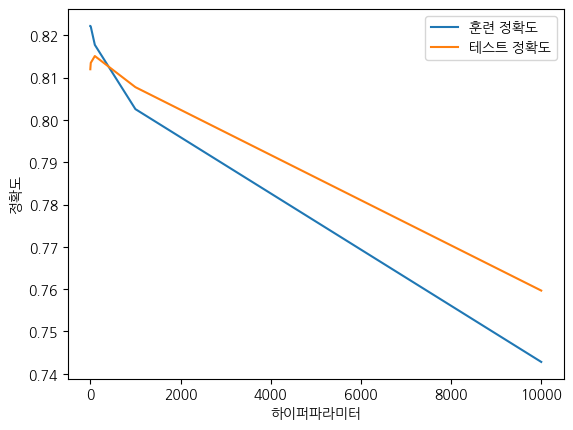

,alpha,train,test
0,0.000001,0.822209,0.811965
1,0.000100,0.822209,0.811965
2,0.000100,0.822209,0.811965
3,0.001000,0.822209,0.811965
4,0.010000,0.822209,0.811967
5,0.100000,0.822209,0.811985
6,1.000000,0.822207,0.812155
7,10.000000,0.822038,0.813475
8,100.000000,0.817734,0.815091
9,1000.000000,0.802543,0.807736


In [16]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = [0.000001,0.0001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for alpha in alpha_list:
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))


result_data = pd.DataFrame({'alpha': alpha_list,
                            'train': train_score,
                            'test': test_score})

plt.figure(dpi=100)

plt.plot(result_data['alpha'], result_data['train'], label = '훈련 정확도')
plt.plot(result_data['alpha'], result_data['test'], label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()
result_data

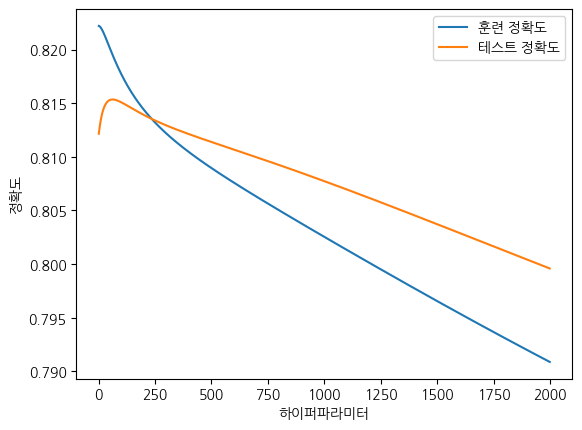

In [17]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in range(1,2000):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()

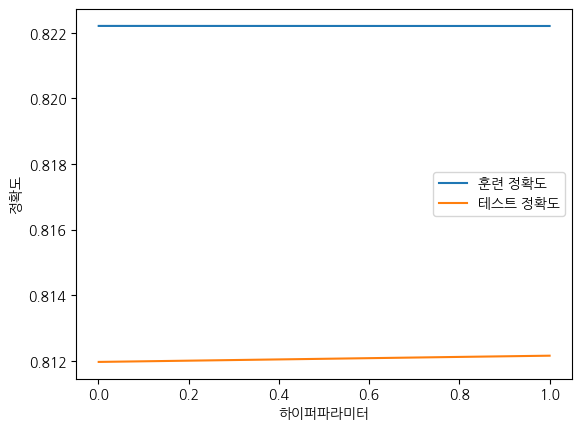

(0.8121554162389146, 0.9999000000000005)

In [18]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.001,1,0.0001):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()
test_max, alpha_test_max

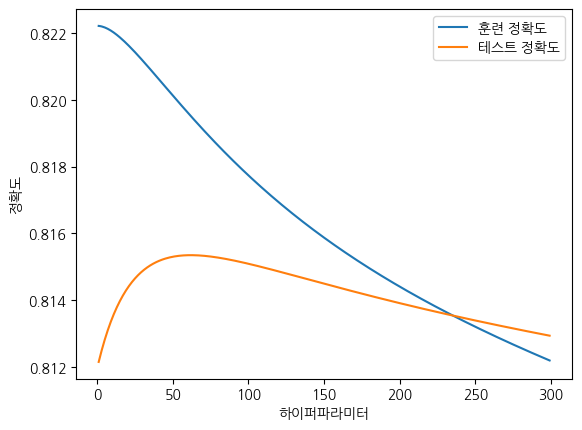

(0.815348766828742, 62)

In [19]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(1,300,1):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()
test_max, alpha_test_max

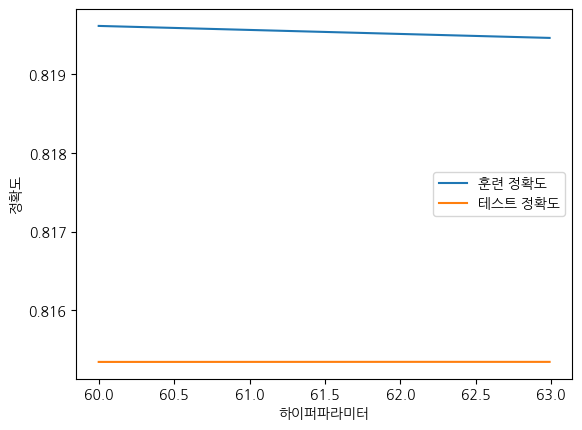

(0.8153487733673568, 61.84999999999963)

In [20]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(60,63,0.01):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()
test_max, alpha_test_max

In [21]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(61.7,62,0.0001):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8153487733689008, 61.847700000004906)

In [22]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(61.847,61.848,0.0000001):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8153487733689014, 61.84765440000765)

In [23]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(61.8476543,61.8476546,0.000000001):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8153487733689014, 61.84765440699963)

In [24]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(61.84765440,61.84765441,0.00000000001):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8153487733689015, 61.84765440792789)

In [25]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(61.8476544079,61.8476544080,0.0000000000001):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8153487733689015, 61.84765440791154)

In [26]:
from sklearn.linear_model import Ridge
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(61.847654407911,61.847654407912,0.00000000000001):
  ridge = Ridge(alpha=alpha).fit(X_train, y_train)

  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8153487733689015, 61.84765440791152)

# Lasso

In [27]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train) #alpha=1 : default

In [28]:
import numpy as np

#score()메서드 => 결정계수 R2(0~1)
# => 훈련데이터, 테스트데이터의 차이를 확인 => Lasso => 과소적합 => 너무 공부를 안했어 => 규제 완화해야함

print('훈련 데이터셋의 R2: ', lasso.score(X_train, y_train))
print('테스트 데이터셋의 R2: ', lasso.score(X_test, y_test))
print('학습에 사용한 특성 개수: ', np.sum(lasso.coef_ != 0))

훈련 데이터셋의 R2:  0.8050985640087276
테스트 데이터셋의 R2:  0.8105652847627943
학습에 사용한 특성 개수:  4


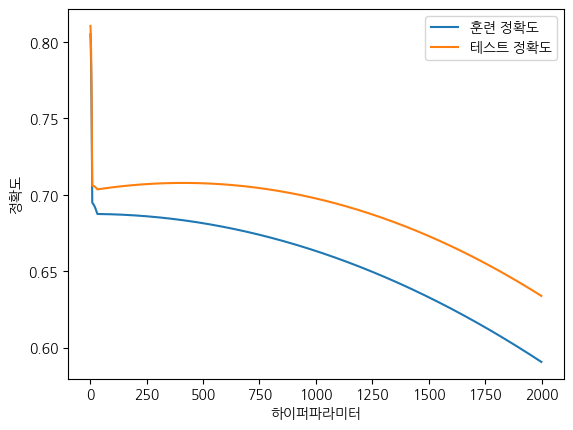

In [29]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []
alpha_list = []

for alpha in range(1,2000):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()

In [30]:
result_data = pd.DataFrame({'alpha': alpha_list,
                            'train': train_score,
                            'test': test_score})

result_data

,alpha,train,test
0,1,0.805099,0.810565
1,2,0.800852,0.807844
2,3,0.793985,0.801682
3,4,0.784369,0.792737
4,5,0.772005,0.781004
...,...,...,...
1994,1995,0.590988,0.634199
1995,1996,0.590891,0.634106
1996,1997,0.590794,0.634013
1997,1998,0.590697,0.633920


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


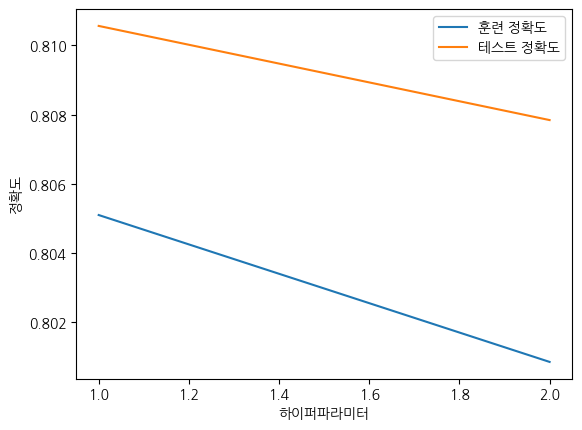

In [31]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []
alpha_list = []

for alpha in range(1,3):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()

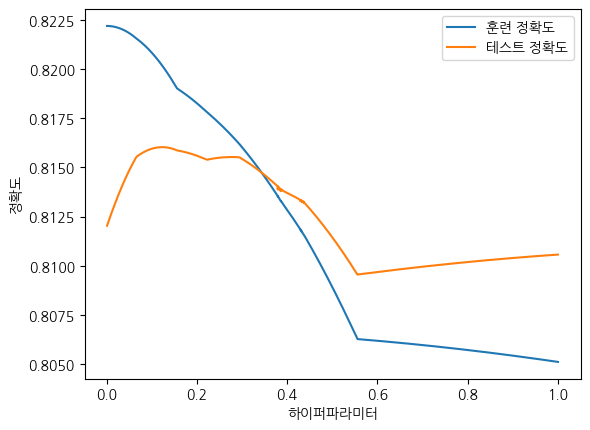

(0.8160353275246321, 0.12310000000000006)

In [33]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.001,1,0.0001):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()
test_max, alpha_test_max

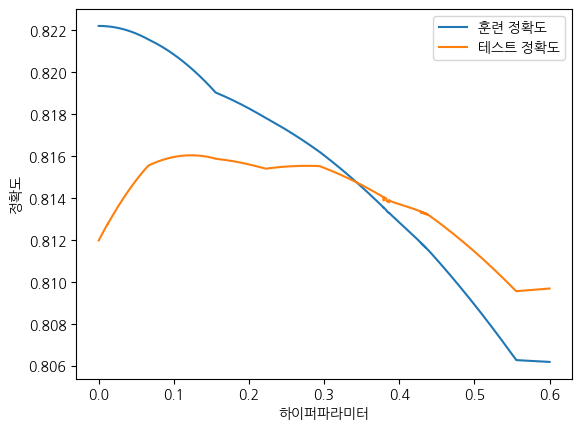

(0.8160353276087744, 0.12308)

In [34]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.0001,0.6,0.00001):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()
test_max, alpha_test_max

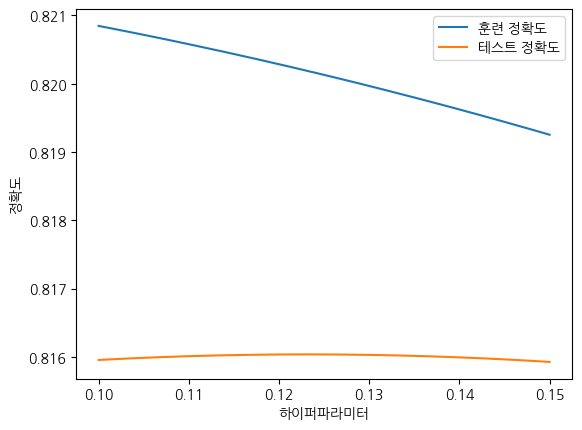

(0.8160353276110768, 0.12307600000002308)

In [35]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.1,0.15,0.000001):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

plt.figure(dpi=100)

plt.plot(alpha_list, train_score, label = '훈련 정확도')
plt.plot(alpha_list, test_score, label = '테스트 정확도')
plt.xlabel('하이퍼파라미터')
plt.ylabel('정확도')
plt.legend()
plt.show()
test_max, alpha_test_max

In [37]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.12306,0.12308,0.00000001):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8160353276110781, 0.12307606999999154)

In [38]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.1230760,0.1230761,0.0000000001):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8160353276110783, 0.12307607549999577)

In [39]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.123076075,0.123076076,0.000000000001):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8160353276110783, 0.12307607504700026)

In [40]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.12307607504,0.12307607505,0.00000000000001):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8160353276110783, 0.12307607504025014)

In [41]:
from sklearn.linear_model import Lasso
train_score = []
test_score = []

alpha_list = []

for alpha in np.arange(0.1230760750402,0.1230760750403,0.0000000000000001):
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)

  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))
  alpha_list.append(alpha)

test_max = max(test_score)
alpha_test_max = alpha_list[test_score.index(test_max)]

test_max, alpha_test_max

(0.8160353276110783, 0.12307607504020263)